# Initialization

In [1]:
!pip install boto3 progressbar2 sfdmap GPUtil

In [2]:
# imports
import pandas as pd
import numpy as np
import os
import sys
import pickle
from matplotlib import pyplot as plt
import matplotlib
import boto3

# random seed
seed = 42
np.random.seed(seed)

# local files paths
local_home_dir_path = os.path.expanduser("~")
local_work_dir_path = os.path.join(local_home_dir_path, 'git')
local_code_dir_path = os.path.join(local_work_dir_path , 'code')

# S3 file paths
endpoint_url = 'https://s3-west.nrp-nautilus.io'
bucket_name = 'tau-astro'
prefix = 'almogh'
s3_work_dir_path = os.path.join(prefix, 'workdir3')
s3_saves_dir_path = os.path.join(s3_work_dir_path , 'model_saves')
s3_data_dir_path = os.path.join(s3_work_dir_path , 'data')
s3_data_ver_dir_path = os.path.join(s3_data_dir_path,'100K_V2')

s3_client = boto3.client("s3", endpoint_url=endpoint_url)

# adding code folder to path
sys.path.insert(1, local_code_dir_path)
from s3 import to_s3_npy, to_s3_pkl, from_s3_npy, from_s3_pkl, to_s3_fig

# Train RF

In [3]:
save_RF = True
save_RF_name = '100K_V2_top10K_SNR'
save_RF_dis_mat = True

load_RF = False
load_RF_name = 'simple___2021_11_27___22_09_00___standard_RF_max_depth_10'

In [4]:
assert not (save_RF and load_RF), '"save" and "load" cant both be "True"'

## Loading data

In [5]:
# load data
print('Loading data and creating dataset')
gs = from_s3_pkl(s3_client, bucket_name, os.path.join(s3_data_ver_dir_path,'gs_100K_V2_top10K_SNR.pkl'))
X = from_s3_npy(s3_client, bucket_name, os.path.join(s3_data_ver_dir_path, 'spec.npy'))
full_wl_grid = from_s3_npy(s3_client, bucket_name, os.path.join(s3_data_dir_path, 'wl_grid.npy'))
wl_grid = from_s3_npy(s3_client, bucket_name, os.path.join(s3_data_ver_dir_path, 'wl_100K_V2.npy'))
start_i = (np.abs(full_wl_grid - wl_grid[0])).argmin()
end_i = 1+(np.abs(full_wl_grid - wl_grid[-1])).argmin()
X = X[gs.index, start_i:end_i]

Loading data and creating dataset
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V2/gs_100K_V2_top10K_SNR.pkl
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V2/spec.npy
loading from uri: s3://tau-astro/almogh/workdir3/data/wl_grid.npy
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V2/wl_100K_V2.npy


In [7]:
assert not np.any(np.isnan(X)), 'NaN!'

## Creating train and test sets for RF

In [11]:
# creaet synthetic samples
print('Creating synthetic data')
shifts = False
if shifts:
    from CustomRandomForest import return_synthetic_data_shift, fix_nan_shifts
    X_syn = return_synthetic_data_shift(X, 10, 3, seed)
    X_syn = fix_nan_shifts(X_syn,10)
else:
    from CustomRandomForest import return_synthetic_data
    X_syn = return_synthetic_data(X, seed)

# merge the data
print('Merging')
from uRF_SDSS import merge_work_and_synthetic_samples
Z, y = merge_work_and_synthetic_samples(X, X_syn)

# train-test split
from sklearn.model_selection import train_test_split
Z_train, Z_test, y_train, y_test, I_train, I_test = train_test_split(Z, y, np.arange(len(y)), train_size=19000, random_state=seed)

  0% (0 of 9600) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Creating synthetic data


100% (9600 of 9600) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


Merging


## Fit a random forest

In [12]:
if load_RF:
    
    s3_load_dir_path = os.path.join(s3_saves_dir_path, 'RF', load_RF_name)
    print('loading from folder (S3): {0}'.format(s3_load_dir_path))
    
    #I_slice = from_s3_npy(s3_client, bucket_name, os.path.join(s3_load_dir_path, 'I_slice.npy'))
    I_train = from_s3_npy(s3_client, bucket_name, os.path.join(s3_load_dir_path, 'I_train.npy'))
    wl_grid = from_s3_npy(s3_client, bucket_name, os.path.join(s3_load_dir_path, 'wl_grid.npy'))
    
    from CustomRandomForest import CustomRandomForest
    rf = CustomRandomForest.load_s3(s3_client, bucket_name, os.path.join(s3_load_dir_path, 'crf.pkl'))
    
else:

    # RF parameters
    N_trees = 500
    min_span = len(wl_grid)
    max_span = len(wl_grid)
    min_samples_split = 1000
    max_features = 'sqrt'
    max_samples = 1.0
    max_depth = 10
    N_snr_bins = 1

    # create a random forest
    from CustomRandomForest import CustomRandomForest
    rf = CustomRandomForest(N_trees=N_trees,
                            min_span=min_span,
                            max_span=max_span,
                            min_samples_split=min_samples_split,
                            max_features=max_features,
                            max_samples=max_samples,
                            max_depth=max_depth
                           )

    # fit the forest to the data
    rf.fit(Z_train, y_train)

    if save_RF:

        # create a save dir
        from datetime import datetime
        s3_save_dir_path = os.path.join(s3_saves_dir_path, 'RF', 'simple___' + datetime.now().strftime("%Y_%m_%d___%H_%M_%S") + '___' + save_RF_name)
        print('save folder (S3): ' + s3_save_dir_path)

        # save some data
        print('Saving numpy arrays')
        #to_s3_npy(I_slice, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'I_slice.npy'))
        to_s3_npy(I_train, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'I_train.npy'))
        #to_s3_npy(wl_grid, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'wl_grid.npy'))

        # save the random forest
        print('Saving the random forest')
        rf.save_s3(s3_client, bucket_name, os.path.join(s3_save_dir_path, 'crf.pkl'))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.2min finished


save folder (S3): almogh/workdir3/model_saves/RF/simple___2022_04_30___20_13_22___100K_V2_top10K_SNR
Saving numpy arrays


NameError: name 'I_slice' is not defined

## Evaluate the RF

In [15]:
if not load_RF:

    print('Predict on training set')
    y_hat_train = rf.predict(Z_train)

    print('Predict on test set')
    y_hat_test = rf.predict(Z_test)

    print('Evaluating')
    from sklearn.metrics import classification_report
    train_set_report = classification_report(y_train, y_hat_train)
    test_set_report = classification_report(y_test, y_hat_test)
    print('TRAININ-SET:')
    print(train_set_report )
    print('TEST-SET:')
    print(test_set_report)

    if save_RF:

        from s3 import log_s3
        log_s3(s3_client, bucket_name, path_in_bucket=s3_save_dir_path, log_name='RF_log.txt',
            #data = '\n'.join([original_wl_str, new_wl_str, samples_str]),
            N_RF_train_real = sum(y_train==1),
            N_RF_train_syn = len(y_train)-sum(y_train==1),
            N_RF_test_real = sum(y_test==1),
            N_RF_test_syn = len(y_test)-sum(y_test==1),
            N_trees = rf.N_trees,
            min_span = rf.min_span,
            max_span = rf.max_span,
            min_samples_split = rf.min_samples_split,
            max_features = rf.max_features,
            max_samples = rf.max_samples,
            max_depth = rf.max_depth,
            train_set_report = '\n'+train_set_report,
            test_set_report = '\n'+test_set_report
            )

Predict on training set
apply: starting 500 jobs


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   12.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished


Predict on test set
apply: starting 500 jobs


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    0.0s


Evaluating
TRAININ-SET:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      9489
         2.0       1.00      1.00      1.00      9511

    accuracy                           1.00     19000
   macro avg       1.00      1.00      1.00     19000
weighted avg       1.00      1.00      1.00     19000

TEST-SET:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       511
         2.0       1.00      1.00      1.00       489

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished


TypeError: log_s3() missing 2 required positional arguments: 'path_in_bucket' and 'log_name'

###  Plots

apply: starting 500 jobs


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished


apply: starting 500 jobs


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   12.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished


saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_04_30___20_13_22___100K_V2_top10K_SNR/prob_dist.png


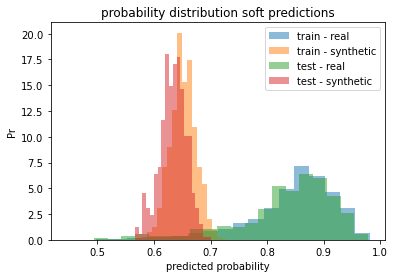

In [20]:
if not load_RF:

    p_test = rf.predict_proba(Z_test)
    p_train = rf.predict_proba(Z_train)

    fig = plt.figure()
    plt.hist(p_train[y_train==1,1], density=True, bins=20, alpha=0.5, label='train - real')
    plt.hist(p_train[y_train==2,2], density=True, bins=20, alpha=0.5, label='train - synthetic')
    plt.hist(p_test[y_test==1,1], density=True, bins=20, alpha=0.5, label='test - real')
    plt.hist(p_test[y_test==2,2], density=True, bins=20, alpha=0.5, label='test - synthetic')
    plt.legend()
    plt.title("probability distribution soft predictions")
    plt.ylabel("Pr")
    plt.xlabel("predicted probability")

    if save_RF:
        to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'prob_dist.png'))

## Calculate similarity matrix, weirdness scores and T-SNE

In [21]:
if load_RF:
    
    print('loading...')
    X = from_s3_npy(s3_client, bucket_name, os.path.join(s3_load_dir_path, 'X.npy'))
    X_leaves = from_s3_npy(s3_client, bucket_name, os.path.join(s3_load_dir_path, 'X_leaves.npy'))
    Y_hat = from_s3_npy(s3_client, bucket_name, os.path.join(s3_load_dir_path, 'Y_hat.npy'))
    sim_mat = from_s3_npy(s3_client, bucket_name, os.path.join(s3_load_dir_path, 'sim_mat.npy'))
    
else:

    # Throwing the RF's test set, and the train synthetic spectra
    """
    because merge_work_and_synthetic_samples concatenates the N synthetic spectra after the N real spectra,
    all the train indices up to N are real.
    """
    X = X[I_train[I_train<X.shape[0]]]

    print('Applying the RF on the full dataset (real spectra only)')
    X_leaves = rf.apply(X)

    print('Predicting fully')
    Y_hat = rf.predict_full_from_leaves(X_leaves)

    print('Calculating the similarity matrix')
    from CustomRandomForest import build_similarity_matrix
    sim_mat = build_similarity_matrix(X_leaves, Y_hat)

    if save_RF:

        print('Saving the data')
        to_s3_npy(X, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'X.npy'))
        to_s3_npy(X_leaves, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'X_leaves.npy'))
        to_s3_npy(Y_hat, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'Y_hat.npy'))

        print('Saving the similarity matrix')
        to_s3_npy(sim_mat, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'sim_mat.npy'))

Applying the RF on the full dataset (real spectra only)
apply: starting 500 jobs


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    5.3s


Predicting fully
Calculating the similarity matrix


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:   25.4s
[Parallel(n_jobs

assembling the matrix.
Saving the data
saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_04_30___20_13_22___100K_V2_top10K_SNR/X.npy
saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_04_30___20_13_22___100K_V2_top10K_SNR/X_leaves.npy
saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_04_30___20_13_22___100K_V2_top10K_SNR/Y_hat.npy
Saving the similarity matrix
saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_04_30___20_13_22___100K_V2_top10K_SNR/sim_mat.npy


In [22]:
print('Calculating the weirdness scores')
dis_mat = 1 - sim_mat
weird_scores = np.mean(dis_mat, axis=1)

if save_RF:

    print('Saving the weirdness scores')
    to_s3_npy(weird_scores, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'weird_scores.npy'))

    if save_RF_dis_mat:
        print('Saving the dissimilarity matrix')
        to_s3_npy(dis_mat, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'dis_mat.npy'))

Calculating the weirdness scores
Saving the weirdness scores
saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_04_30___20_13_22___100K_V2_top10K_SNR/weird_scores.npy
Saving the dissimilarity matrix
saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_04_30___20_13_22___100K_V2_top10K_SNR/dis_mat.npy


In [23]:
if load_RF:
    
    print('loading...')
    sne = from_s3_npy(s3_client, bucket_name, os.path.join(s3_load_dir_path, 'tsne.npy'))
    
else:

    print('Running T-SNE')
    from sklearn.manifold import TSNE
    sne = TSNE(n_components=2, perplexity=25, metric='precomputed', verbose=1, random_state=seed).fit_transform(dis_mat)

    if save_RF:

        print('Saving T-SNE')
        to_s3_npy(sne, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'tsne.npy'))

Running T-SNE
[t-SNE] Computing 76 nearest neighbors...


/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Indexed 9489 samples in 0.123s...
[t-SNE] Computed neighbors for 9489 samples in 1.206s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9489
[t-SNE] Computed conditional probabilities for sample 2000 / 9489
[t-SNE] Computed conditional probabilities for sample 3000 / 9489
[t-SNE] Computed conditional probabilities for sample 4000 / 9489
[t-SNE] Computed conditional probabilities for sample 5000 / 9489
[t-SNE] Computed conditional probabilities for sample 6000 / 9489
[t-SNE] Computed conditional probabilities for sample 7000 / 9489
[t-SNE] Computed conditional probabilities for sample 8000 / 9489
[t-SNE] Computed conditional probabilities for sample 9000 / 9489
[t-SNE] Computed conditional probabilities for sample 9489 / 9489
[t-SNE] Mean sigma: 0.071634
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.856674
[t-SNE] KL divergence after 1000 iterations: 3.012390
Saving T-SNE
saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple

# Plots

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_04_30___20_13_22___100K_V2_top10K_SNR/weirdness_scores_histogram.png


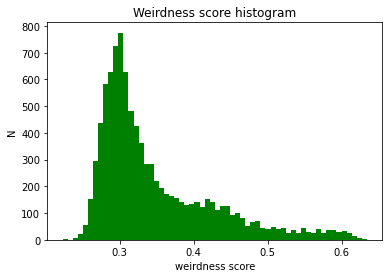

In [24]:
if not load_RF:
    
    fig = plt.figure()
    tmp = plt.hist(weird_scores, bins=60, color="g")
    plt.title("Weirdness score histogram")
    plt.ylabel("N")
    plt.xlabel("weirdness score")

    if save_RF:
        to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'weirdness_scores_histogram.png'))

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_04_30___20_13_22___100K_V2_top10K_SNR/distances_histogram.png


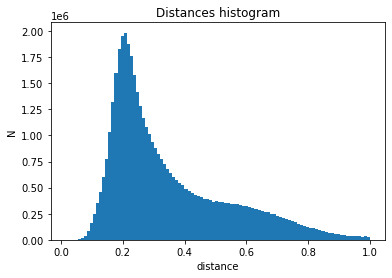

In [25]:
if not load_RF:

    distances = dis_mat[np.tril_indices(dis_mat.shape[0], -1)]

    fig = plt.figure()
    tmp = plt.hist(distances, bins=100)
    plt.title("Distances histogram")
    plt.ylabel("N")
    plt.xlabel("distance")

    if save_RF:
        to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'distances_histogram.png'))

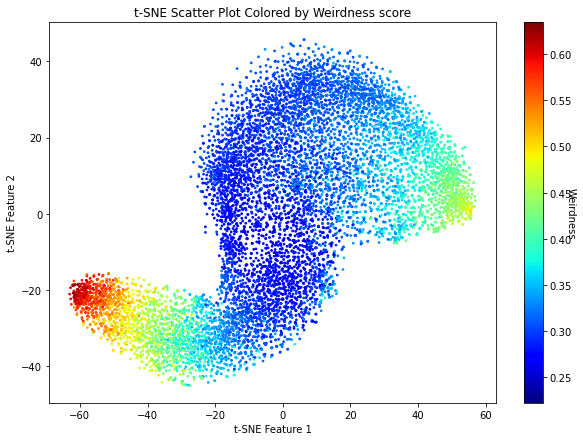

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_04_30___20_13_22___100K_V2_top10K_SNR/tsne_colored_by_weirdness.png


In [26]:
if not load_RF:
    
    sne_f1 = sne[:, 0]
    sne_f2 = sne[:, 1]

    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111)
    im_scat = ax.scatter(sne_f1, sne_f2, s=3, c=weird_scores, cmap=plt.cm.get_cmap('jet'), picker=1)
    ax.set_xlabel('t-SNE Feature 1')
    ax.set_ylabel('t-SNE Feature 2')
    ax.set_title(r't-SNE Scatter Plot Colored by Weirdness score')
    clb = fig.colorbar(im_scat, ax=ax)
    clb.ax.set_ylabel('Weirdness', rotation=270)
    plt.show()

    if save_RF:
        to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'tsne_colored_by_weirdness.png'))

In [48]:
I_real_train = I_train[I_train<10000]
snr = gs.snMedian.iloc[I_real_train]

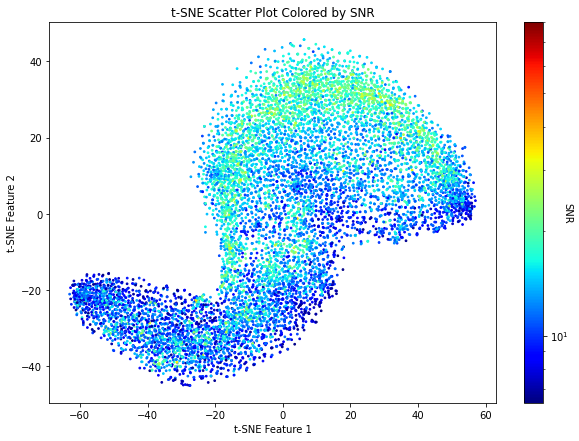

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_04_30___20_13_22___100K_V2_top10K_SNR/tsne_colored_by_snr.png


In [53]:
if not load_RF:
    
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111)
    import matplotlib.colors as colors
    im_scat = ax.scatter(sne_f1, sne_f2, s=3, c=snr, cmap=plt.cm.get_cmap('jet'), norm=colors.LogNorm(vmin=snr.min(), vmax=80))
    ax.set_xlabel('t-SNE Feature 1')
    ax.set_ylabel('t-SNE Feature 2')
    ax.set_title(r't-SNE Scatter Plot Colored by SNR')
    clb = fig.colorbar(im_scat, ax=ax)
    clb.ax.set_ylabel('SNR', rotation=270)
    plt.show()

if save_RF:
    to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'tsne_colored_by_snr.png'))